In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from plotting import plot_performance_matrix
from rfc_helpers import rfc_feature_importance_analysis, stratified_k_fold, plot_rfc_feature_importances
from utils import get_study_metrics_data, get_performance_matrix
import numpy as np
import pandas as pd
import pprint


In [4]:
#studies_to_exclude = ['neurocube_quiroga_easy2', 'synth_mearec_neuronexus_noise10_K20_C32', 'neurocube_quiroga_easy1', 'neurocube_quiroga_difficult1', 'mea_c30', 'paired_monotrode_boyden32c', 'neurocube_sim2_11K20', 'paired_monotrode_mea64c', 'paired_english', 'synth_mearec_neuronexus_noise20_K40_C32', 'neurocube_quiroga_difficult2', 'paired_crcns', 'paired_monotrode_kampff', 'synth_mearec_neuronexus_noise20_K20_C32', 'synth_mearec_neuronexus_noise20_K10_C32', 'paired_kampff', 'paired_monotrode_crcns', 'synth_mearec_neuronexus_noise10_K10_C32', 'neurocube_sim2_2K10', 'paired_boyden32c', 'paired_mea64c', 'synth_mearec_neuronexus_noise10_K40_C32']
#ALL_AVAILABLE_STUDY_SETS=['HYBRID_JANELIA', 'LONG_DRIFT', 'LONG_STATIC', 'MANUAL_FRANKLAB', 'PAIRED_BOYDEN', 'PAIRED_CRCNS_HC1', 'PAIRED_ENGLISH', 'PAIRED_KAMPFF', 'PAIRED_MEA64C_YGER', 'PAIRED_MONOTRODE', 'SYNTH_BIONET', 'SYNTH_MAGLAND', 'SYNTH_MEAREC_NEURONEXUS', 'SYNTH_MEAREC_TETRODE', 'SYNTH_MONOTRODE', 'SYNTH_VISAPY']
#STUDY_NAMES = [study_name for study_set_name in ['HYBRID_JANELIA', 'LONG_STATIC', 'SYNTH_MAGLAND', 'SYNTH_MEAREC_TETRODE'] for study_name in SFStudySet.load(study_set_name).get_study_names() if study_name not in studies_to_exclude]

# Hybrid Janelia static only (no drift)
STUDY_NAMES = ['hybrid_static_tetrode', 'hybrid_static_siprobe',
               'LONG_STATIC_1200s_8c', 'LONG_STATIC_600s_8c', 'LONG_STATIC_300s_16c', 'LONG_STATIC_4800s_16c',
               'LONG_STATIC_300s_8c', 'LONG_STATIC_2400s_8c', 'LONG_STATIC_2400s_16c', 'LONG_STATIC_600s_16c',
               'LONG_STATIC_1200s_16c', 'LONG_STATIC_4800s_8c', 'synth_magland_noise20_K20_C8',
               'synth_magland_noise10_K10_C4', 'synth_magland_noise10_K10_C8', 'synth_magland_noise20_K10_C4',
               'synth_magland_noise20_K20_C4', 'synth_magland_noise20_K10_C8', 'synth_magland_noise10_K20_C8',
               'synth_magland_noise10_K20_C4', 'synth_mearec_tetrode_noise10_K20_C4', 'synth_mearec_tetrode_noise10_K10_C4',
               'synth_mearec_tetrode_noise20_K10_C4', 'synth_mearec_tetrode_noise20_K20_C4']

STATIC_SIPROBE_STUDY_NAMES = ['hybrid_static_siprobe', 'LONG_STATIC_1200s_8c', 'LONG_STATIC_600s_8c', 'LONG_STATIC_300s_16c',
                       'LONG_STATIC_4800s_16c', 'LONG_STATIC_300s_8c', 'LONG_STATIC_2400s_8c', 'LONG_STATIC_2400s_16c',
                       'LONG_STATIC_600s_16c', 'LONG_STATIC_1200s_16c', 'LONG_STATIC_4800s_8c',]

STATIC_TETRODE_STUDY_NAMES = ['hybrid_static_tetrode', 'synth_magland_noise20_K20_C8', 'synth_magland_noise10_K10_C4',
                       'synth_magland_noise10_K10_C8', 'synth_magland_noise20_K10_C4', 'synth_magland_noise20_K20_C4',
                       'synth_magland_noise20_K10_C8', 'synth_magland_noise10_K20_C8', 'synth_magland_noise10_K20_C4',
                       'synth_mearec_tetrode_noise10_K20_C4', 'synth_mearec_tetrode_noise10_K10_C4',
                       'synth_mearec_tetrode_noise20_K10_C4', 'synth_mearec_tetrode_noise20_K20_C4']

METRIC_NAMES = [ "firing_rate", "presence_ratio", "isi_violation",
                 "amplitude_cutoff", "snr", "max_drift", "cumulative_drift",
                 "silhouette_score", "isolation_distance", "l_ratio",
                 "nn_hit_rate", "nn_miss_rate", "d_prime"]

SORTER_NAMES = ['HerdingSpikes2', 'IronClust', 'JRClust',
                'KiloSort', 'KiloSort2', 'Klusta', 'mountainsort4',
                'SpykingCircus', 'Tridesclous']

RANDOM_STATE = 0

In [5]:
# Loads in relevant datasets
static_tetrode_metric_data = get_study_metrics_data(
        study_names=STATIC_TETRODE_STUDY_NAMES,
        metric_names=METRIC_NAMES,
        random_state=RANDOM_STATE,
        sorter_names=SORTER_NAMES,
        transformation=lambda x: pd.DataFrame(normalize(x.to_numpy(), axis=0), columns=x.columns),
        include_meta=True
    )

static_siprobe_metric_data = get_study_metrics_data(
        study_names=STATIC_SIPROBE_STUDY_NAMES,
        metric_names=METRIC_NAMES,
        random_state=RANDOM_STATE,
        sorter_names=SORTER_NAMES,
        transformation=lambda x: pd.DataFrame(normalize(x.to_numpy(), axis=0), columns=x.columns),
        include_meta=True
    )

### Random forest classifier feature importance ranking
Runs Stratified 5-Fold cross validation of a RandomForestClassifier using 80% of available tetrode data.

Displays the ranked feature importances of the best performing random forest,
showing the standard deviation of importances over the 5 folds as error bars
Also displays the first decision tree from within the best performing forest.

train -  [6489 1531]   |   test -  [1623  382]
train -  [6489 1531]   |   test -  [1623  382]
train -  [6490 1530]   |   test -  [1622  383]
train -  [6490 1530]   |   test -  [1622  383]
train -  [6490 1530]   |   test -  [1622  383]
Trained on 10025; Tested on 2507
('F1 Score for each RFC on held out test set: [0.9352051835853132, '
 '0.9253731343283581, 0.9293361884368307, 0.9301825993555316, '
 '0.9316239316239316]; mean=0.930344207465993; std=0.0031943879049748723')
train -  [3588  812]   |   test -  [898 202]
train -  [3589  811]   |   test -  [897 203]
train -  [3589  811]   |   test -  [897 203]
train -  [3589  811]   |   test -  [897 203]
train -  [3589  811]   |   test -  [897 203]
Trained on 5500; Tested on 1375
('F1 Score for each RFC on held out test set: [0.9598214285714285, '
 '0.9665924276169263, 0.9523809523809523, 0.9594594594594594, '
 '0.9686098654708519]; mean=0.9613728266999237; std=0.005771318359315315')


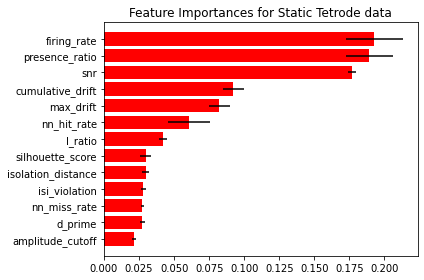

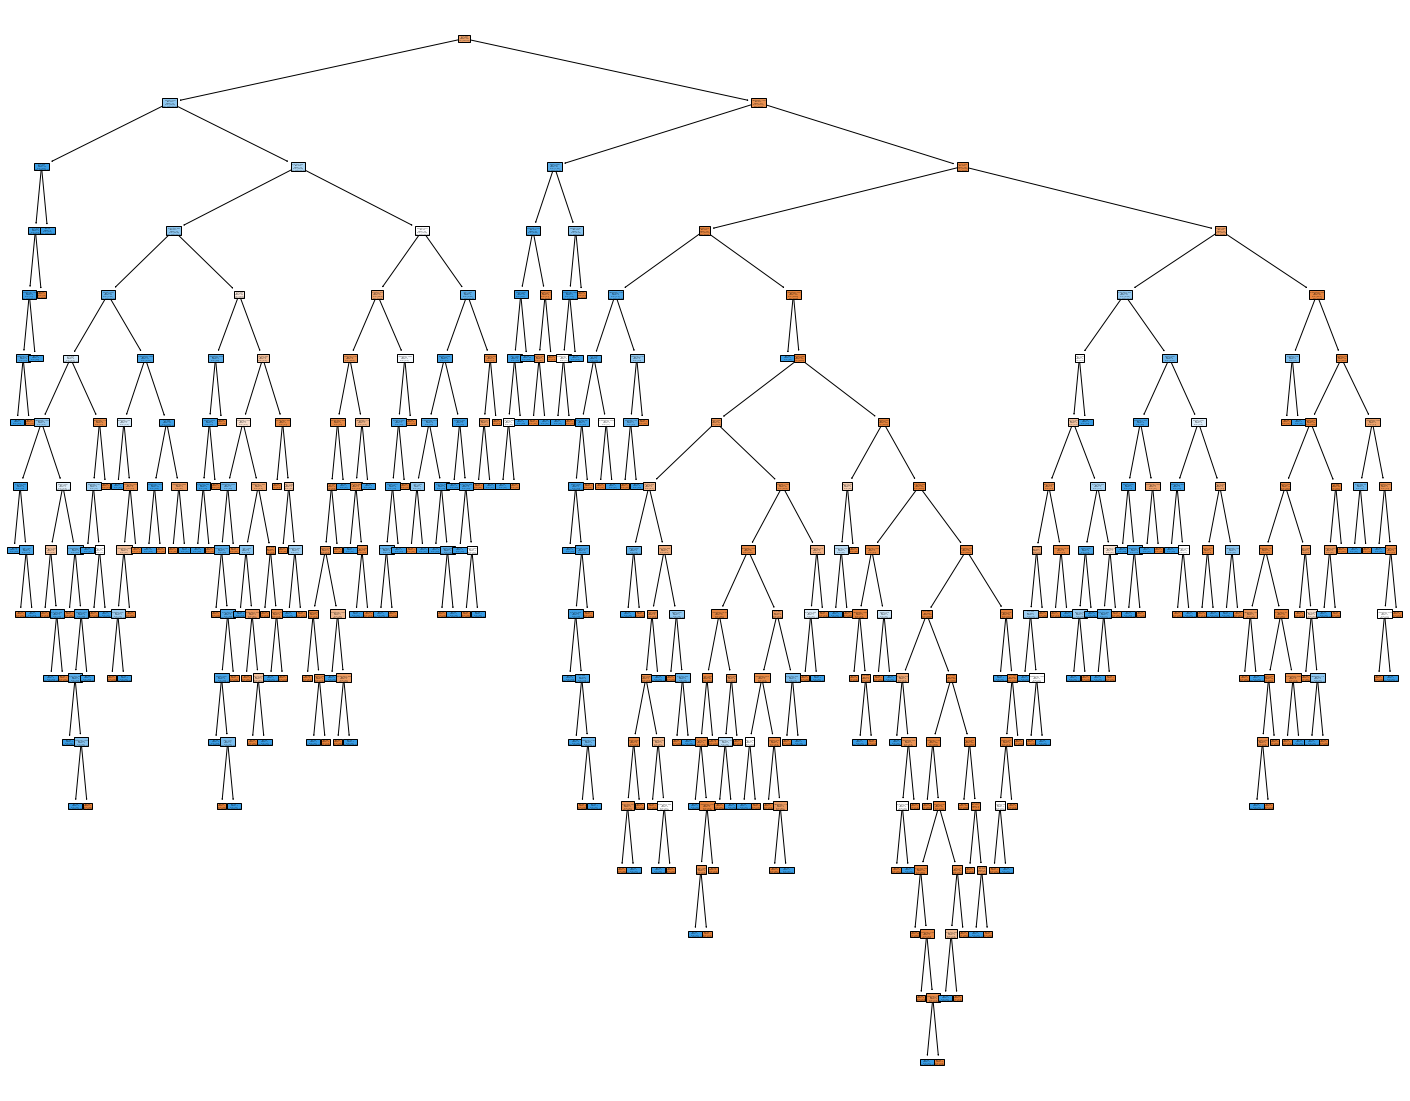

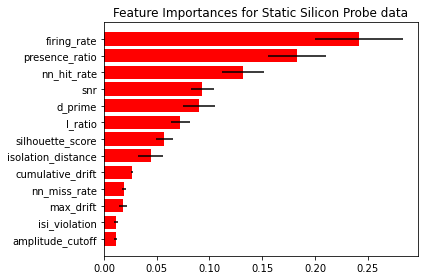

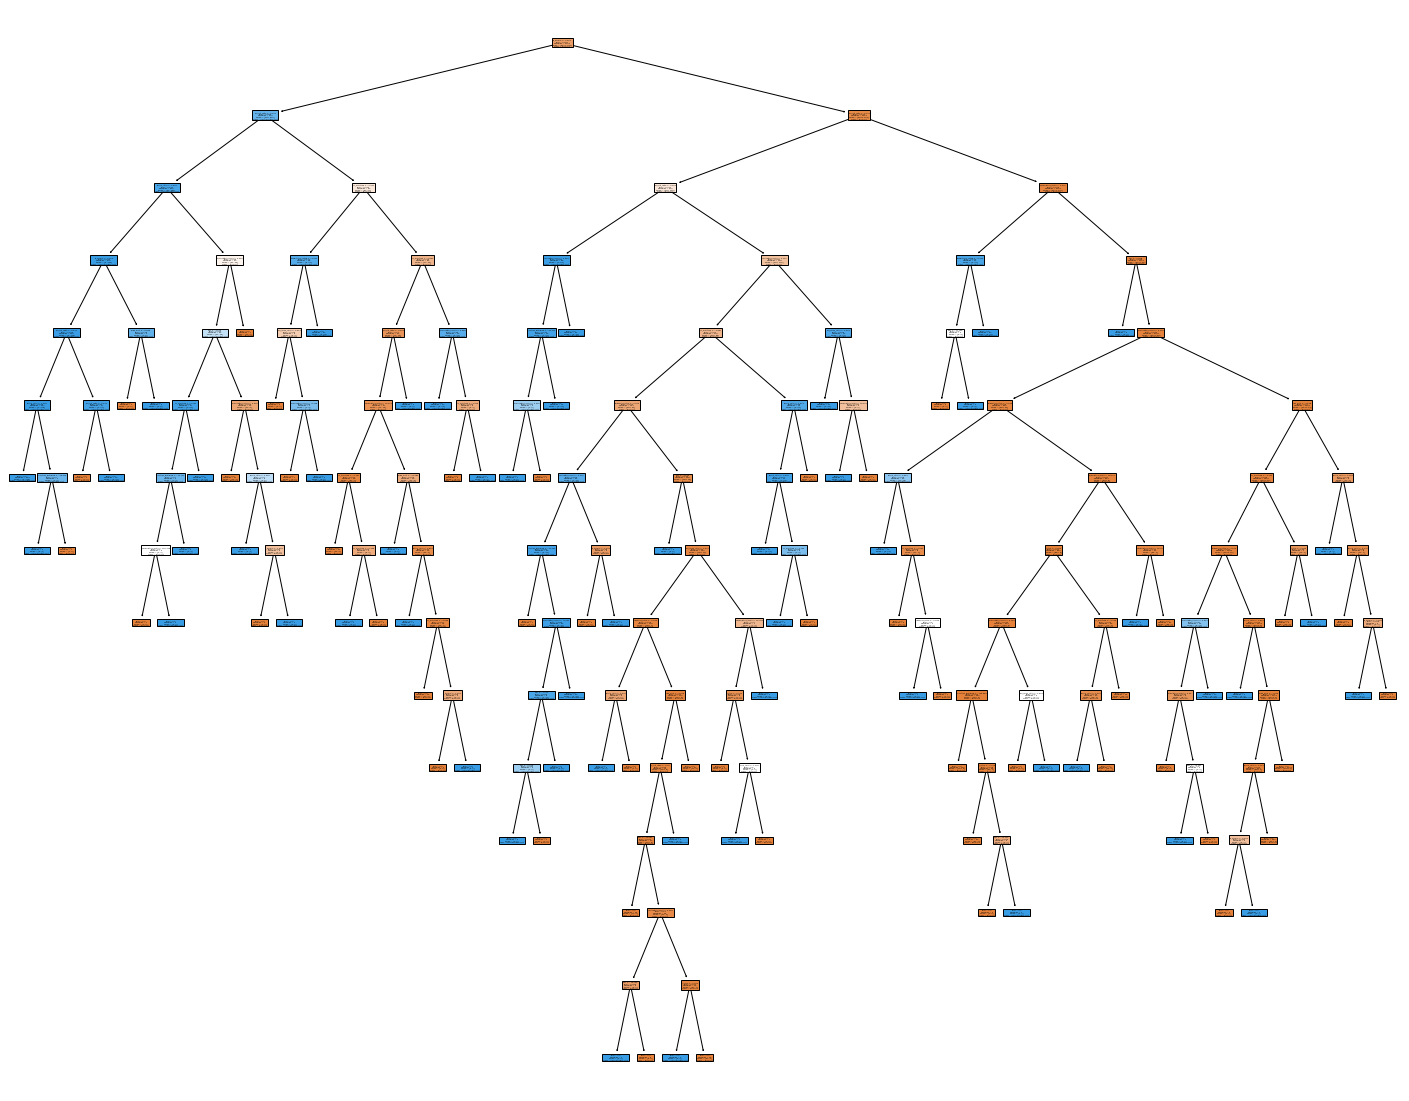

In [4]:
X_train_static_tetrode, X_test_static_tetrode, y_train_static_tetrode, y_test_static_tetrode = train_test_split(static_tetrode_metric_data.drop(columns=['sorterName', 'recordingName', 'studyName', 'fp']),
                                                    static_tetrode_metric_data['fp'], test_size=0.2, random_state=RANDOM_STATE)


X_train_static_siprobe, X_test_static_siprobe, y_train_static_siprobe, y_test_static_siprobe = train_test_split(static_siprobe_metric_data.drop(columns=['sorterName', 'recordingName', 'studyName', 'fp']),
                                                    static_siprobe_metric_data['fp'], test_size=0.2, random_state=RANDOM_STATE)


rfc_feature_importance_analysis(
    X_train=X_train_static_tetrode, y_train= y_train_static_tetrode,
    X_test=X_test_static_tetrode, y_test=y_test_static_tetrode,
    metric_names=METRIC_NAMES, fig_title='Feature Importances for Static Tetrode data',
    feature_importance_output='/home/mclancy/truespikes/figures/feature_selection/feature_importance/static_tetrode_feature_importances.pdf',
    tree_output='/home/mclancy/truespikes/figures/feature_selection/feature_importance/static_tetrode_tree_sample.pdf'
)

rfc_feature_importance_analysis(
    X_train=X_train_static_siprobe, y_train=y_train_static_siprobe,
    X_test=X_test_static_siprobe, y_test=y_test_static_siprobe,
    metric_names=METRIC_NAMES, fig_title='Feature Importances for Static Silicon Probe data',
    feature_importance_output='/home/mclancy/truespikes/figures/feature_selection/feature_importance/static_siprobe_feature_importances.pdf',
    tree_output='/home/mclancy/truespikes/figures/feature_selection/feature_importance/static_siprobe_tree_sample.pdf'
)

### Feature importances for models trained on individual sorter tetrode data.

train -  [542 462]   |   test -  [135 116]
train -  [542 462]   |   test -  [135 116]
train -  [542 462]   |   test -  [135 116]
train -  [541 463]   |   test -  [136 115]
train -  [541 463]   |   test -  [136 115]
Trained on 1255; Tested on 314
('F1 Score for each RFC on held out test set: [0.9936305732484078, '
 '0.9904153354632588, 0.9904153354632588, 0.9904153354632588, '
 '0.9904153354632588]; mean=0.9910583830202885; std=0.0012860951140595935')
train -  [471  21]   |   test -  [118   5]
train -  [471  21]   |   test -  [118   5]
train -  [471  21]   |   test -  [118   5]
train -  [471  21]   |   test -  [118   5]
train -  [472  20]   |   test -  [117   6]
Trained on 615; Tested on 154
('F1 Score for each RFC on held out test set: [0.9090909090909091, '
 '0.9090909090909091, 0.9090909090909091, 0.9090909090909091, '
 '0.9090909090909091]; mean=0.909090909090909; std=1.1102230246251565e-16')
train -  [522 111]   |   test -  [131  28]
train -  [522 111]   |   test -  [131  28]
train

/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/

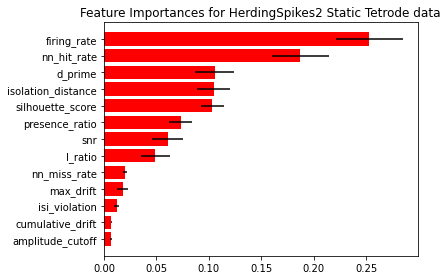

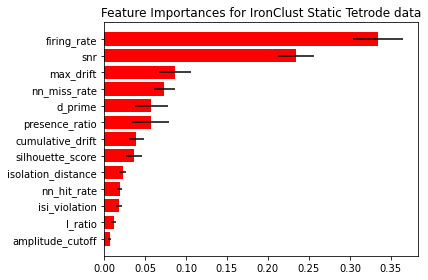

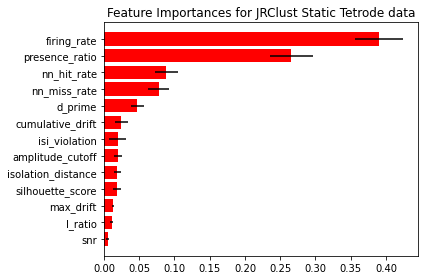

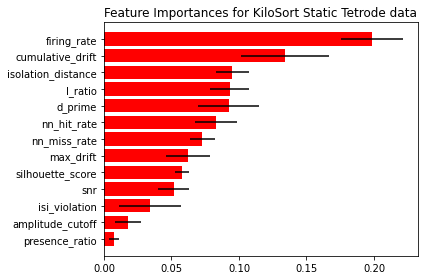

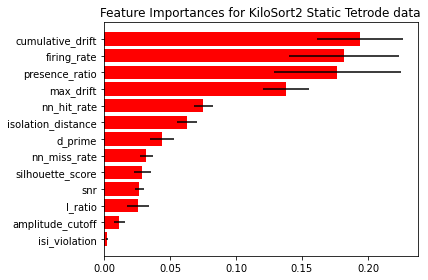

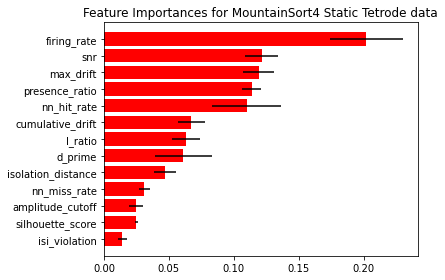

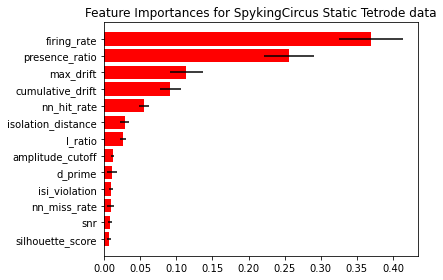

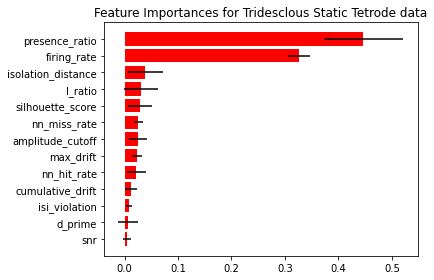

In [5]:
for sorter_name, df in static_siprobe_metric_data.groupby('sorterName'):

    X_train_static_tetrode, X_test_static_tetrode, y_train_static_tetrode, y_test_static_tetrode = \
        train_test_split(df.drop(columns=['sorterName', 'recordingName', 'studyName', 'fp']),
                         df['fp'], test_size=0.2, random_state=RANDOM_STATE)

    rfcs, scores = stratified_k_fold(
        model_cls=, model_args=None,
        X=X_train_static_tetrode, y=y_train_static_tetrode, n_splits=5
    )
    # importance_ranked_metrics = ([[metric_names[i] for i in np.argsort(rfc.feature_importances_)] for rfc in rfcs])

    # plot_rfc_feature_importances(rfcs=rfcs, scores=scores, metric_names=METRIC_NAMES, title=f'Feature Importances for {sorter_name} Static Tetrode data', output=f'/home/mclancy/truespikes/figures/feature_selection/feature_importance/by_sorter/static_tetrode_feature_importances_{sorter_name}.pdf')

    print(f'Trained on {X_train_static_tetrode.shape[0]}; Tested on {X_test_static_tetrode.shape[0]}')

    test_set_f1_scores = [f1_score(rfc.predict(X_test_static_tetrode), y_test_static_tetrode) for rfc in rfcs]
    pprint.pprint(f"F1 Score for each RFC on held out test set: {test_set_f1_scores}; "
                  f"mean={np.mean(test_set_f1_scores)}; std={np.std(test_set_f1_scores)}")


In [6]:
# Loads in relevant datasets
static_tetrode_metric_data = get_study_metrics_data(
        study_names=STATIC_TETRODE_STUDY_NAMES,
        metric_names=METRIC_NAMES,
        random_state=RANDOM_STATE,
        sorter_names=SORTER_NAMES,
        by_sorter=True,
        train_test_split=True,
    )

performance_matrix = get_performance_matrix(datasets=static_tetrode_metric_data, model_cls=RandomForestClassifier, metric=f1_score)

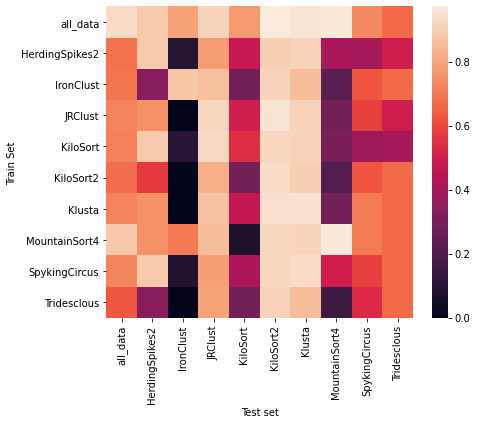

In [7]:
plot_performance_matrix(performance_matrix, figsize=(7,6), save_path='/home/mclancy/truespikes/figures/model_selection/f1_scores_static_tetrode_by_sorters.pdf')